# License

    Copyright (C) 2015-2016, Andrew W. Steiner

    This is based on the excellent work by Dany Page at
    http://www.astroscu.unam.mx/neutrones/home.html

    This program is free software; you can redistribute it
    and/or modify it under the terms of the GNU General Public License
    as published by the Free Software Foundation; either version 3 of
    the License, or (at your option) any later version.

    This program is distributed in the hope that it will be
    useful, but WITHOUT ANY WARRANTY; without even the implied warranty
    of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU
    General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program. If not, see http://www.gnu.org/licenses/ .

## Perform imports:

In [2]:
import os
import math
from math import cos
from math import sin
from math import sqrt
from matplotlib.patches import Ellipse
from matplotlib.patches import Rectangle
from pylab import rand
import matplotlib.pyplot as plot
import numpy
import os
import urllib.request
try:
    import o2py
except ImportError:
    urllib.request.urlretrieve('http://raw.githubusercontent.com/awsteiner/o2scl'+
         '/master/src/other/o2py.py','o2py.py')
    try:
        import o2py
    except:
        raise ImportError('Could not import o2py, even after download.')
print('Success.')

Success.


# Global plot file update parameter

In [3]:
update_plot_files=True

# Neutron star plotting class definition

In [4]:
class nstar_plot:

    pi=math.acos(-1)
    # Default text color
    text_color='white'
    # Background color
    bkgd_color='black'
    # Color for atmosphere
    atmos_color='red'
    # Color for crust
    crust_color=(1.0,0.5,0.5)
    # Color for outer core
    core_color=(0.75,0.75,1.0)
    # Color for inner core
    inner_color=(0.5,0.5,1.0)
    # Color for neutron drip
    neutron_color=(0.875,0.625,0.75)
    # Figure object
    fig=0
    # Axis object
    ax=0
    
    # Default plot function from O2scl
    def default_plot(self,lmar=0.14,bmar=0.12,rmar=0.04,tmar=0.04):
        plot.rc('text',usetex=True)
        plot.rc('font',family='serif')
        plot.rcParams['lines.linewidth']=0.5
        self.fig=plot.figure(1,figsize=(8.0,8.0))
        self.ax=plot.axes([lmar,bmar,1.0-lmar-rmar,1.0-tmar-bmar])
        plot.grid(False)

    """
    Initialize the plot, and make sure the limits are from (0,0) 
    to (1,1) by plotting a couple small lines.
    """
    def init(self):
        self.default_plot(0.0,0.0,0.0,0.0)
        plot.plot([0,0.01],[0,0.01],color=self.bkgd_color,ls='-')
        plot.plot([0.99,1.0],[0.99,1.0],color=self.bkgd_color,ls='-')

    # Form the base black background
    def bkgd(self):
        # Black background
        main_bkgd=Rectangle((0,0),1,1)
        main_bkgd.set_facecolor(self.bkgd_color)
        self.ax.add_artist(main_bkgd)

    """
    The star's surface, red and yellow, created from a series of 
    circles
    """
    def base_star(self):
        # Base star
        N=100
        ang=0
        for i in range(0,N):
            centx=0.5-float(i)*0.14/N
            centy=0.5+float(i)*0.14/N
            size1=0.6-float(i)*0.56/N
            size2=0.6-float(i)*0.56/N
            green=float(i)/N
            base=Ellipse((centx,centy),size1,size2,lw=0,angle=ang)
            base.set_facecolor((1,green,0))
            self.ax.add_artist(base)
            
    """
    Plot the magnetic field
    
    This is a pure dipole field given by 
    
    \vec{B} = 3 \vec{r} (m dot r)/r^5 - \vec{m}/r^3
    """
    def mag_field(self,ord):
        mx=0.5
        my=-0.5
        fact=400
        N=10
        # vector field
        for i in range(0,N+1):
            for j in range(0,11):
                rx=-0.5+float(i)/N
                ry=-0.5+float(j)/N
                rmag=sqrt(rx*rx+ry*ry)
                if rmag>0.3:
                    dot=mx*rx+my*ry
                    Bx=(3*rx*dot/rmag**5-mx/rmag**3)/fact
                    By=(3*ry*dot/rmag**5-my/rmag**3)/fact
                    self.ax.arrow(rx+0.5+Bx,ry+0.5+By,-Bx,-By,
                             head_width=0.01,head_length=0.03,color='blue',
                             zorder=ord)
        # Arrow for magnetic north
        ang2=3*self.pi/4+0.1
        self.ax.arrow(0.5+0.2*cos(ang2),
                 0.5+0.2*sin(ang2),
                 0.23*cos(ang2),
                 0.23*sin(ang2),
                 head_width=0.01,head_length=0.03,color='cyan',
                 zorder=ord)
        # Arrow for magnetic south
        self.ax.arrow(0.5+0.3*cos(ang2+self.pi),
                 0.5+0.3*sin(ang2+self.pi),
                 0.1*cos(ang2+self.pi),
                 0.1*sin(ang2+self.pi),
                 head_width=0.01,head_length=0.03,color='cyan',
                 zorder=ord)
        """
        Label for B field magnitude
        
        B=2e15 for SGR 1806-20 from Woods et al. (2006),
        http://dx.doi.org/10.1086/507459 .

        B=10^7 is estimate from P-Pdot diagrams, e.g.
        from arxiv.org/abs/1103.4538 
        """
        self.ax.text(0.17,0.72,
                     r'$B_{\mathrm{surf}}\sim 10^{7-15}~\mathrm{G}$',
                     fontsize=24,color='cyan',va='center',
                     ha='center',zorder=ord+1,
                     bbox=dict(facecolor=self.bkgd_color,lw=0))

    """
    Cutaway function
    
    Based on the polar form for an ellipse:
    r = a b / sqrt( (b*cos(t))^2 + (a*sin(t))^2 )
    where a is the radius in the x direction and b is the radius in
    the y direction.
    """
    def cutaway(self,factor,cname,ord):
        # Number of points per arc
        N2=100
        # Upper left part, from pi/2 to pi
        x=[]
        top_y=[]
        bot_y=[]
        ell_b=0.3*factor
        ell_a=0.1*factor
        for i in range(0,N2):
            angle=self.pi-float(i)/(N2-1)*(self.pi/2.0)
            r=ell_a*ell_b/sqrt((ell_b*cos(angle))**2+(ell_a*sin(angle))**2)
            x.append(0.5+r*cos(angle))
            top_y.append(0.5+r*sin(angle))
            if angle>self.pi*3.0/4.0:
                angle2=2*self.pi-angle
                bot_y.append(0.5+r*sin(angle2))
            else:
                bot_y.append(0.5+r*cos(angle))
        self.ax.fill_between(x,bot_y,top_y,facecolor=cname,lw=0,zorder=ord)

        # Upper right part, from 0 to pi/2
        x=[]
        top_y=[]
        bot_y=[]
        ell_b=0.3*factor
        ell_a=0.2*factor
        for i in range(0,N2):
            angle=self.pi/2-float(i)/(N2-1)*(self.pi/2)
            r=ell_a*ell_b/sqrt((ell_b*cos(angle))**2+(ell_a*sin(angle))**2)
            x.append(0.5+r*cos(angle))
            top_y.append(0.5+r*sin(angle))
            if angle>self.pi/8.0:
                bot_y.append(0.5-r*cos(angle)/4*1.5)
            else:
                bot_y.append(0.5+r*sin(-angle))
        self.ax.fill_between(x,bot_y,top_y,facecolor=cname,lw=0,zorder=ord)

        # Lower part, from 5*pi/4 to 15*pi/8
        x=[]
        top_y=[]
        bot_y=[]
        ell_b=0.1*factor
        ell_a=0.3*factor
        for i in range(0,N2):
            angle=5*self.pi/4+float(i)/(N2-1)*(5.02*self.pi/8)
            r=ell_a*ell_b/sqrt((ell_b*cos(angle))**2+(ell_a*sin(angle))**2)
            x.append(0.5+r*cos(angle))
            bot_y.append(0.5+r*sin(angle))
            if angle>3*self.pi/2:
                top_y.append(0.5-r*cos(angle)/4*1.5)
            else:
                top_y.append(0.5+r*cos(angle))
        self.ax.fill_between(x,bot_y,top_y,facecolor=cname,lw=0,zorder=ord)

    """
    Arrows and label for rotation

    716 Hz from Hessels et al. (2006), 
    http://dx.doi.org/10.1126/science.1123430 .

    1/11.79 Hz from Rim and Kaspi (2014),
    http://dx.doi.org/10.1088/0004-637X/784/1/37 .
    
    Now 4.2e-5 Hz from D'Ai et al. (2016),
    http://dx.doi.org/10.1093/mnras/stw2023
    """
    def rotation(self,ord):
        ang3=3*self.pi/4-0.1
        self.ax.arrow(0.5+0.2*cos(ang3),0.5+0.2*sin(ang3),
                      0.15*cos(ang3),0.15*sin(ang3),
                      head_width=0.01,head_length=0.03,color=(0.2,0.8,0.2),
                      zorder=ord)
        self.ax.arrow(0.5+0.3*cos(ang3+self.pi),
                      0.5+0.3*sin(ang3+self.pi),
                      0.07*cos(ang3+self.pi),
                      0.07*sin(ang3+self.pi),
                      head_width=0.01,head_length=0.03,color=(0.2,0.8,0.2),
                      zorder=ord)
        self.ax.text(0.25,0.84,r'$\mathrm{freq.}=4.2\times 10^{-5}-720~\mathrm{Hz}$',
                     fontsize=24,color=(0.2,0.8,0.2),va='center',
                     ha='center',zorder=ord+1,
                     bbox=dict(facecolor=self.bkgd_color,lw=0))

    """
    Axes for the cutaway
    
    Radius range from Steiner, et al. (2016)
    http://dx.doi.org/10.1088/2041-8205/765/1/L5
    """
    def cutaway_axes(self,ord):
        # axes
        plot.plot([0.5,0.5+0.21*cos(15*self.pi/8)],
                  [0.5,0.5+0.21*sin(15*self.pi/8)],
                  color='black',ls='-',lw=1.5,zorder=ord)
        plot.plot([0.5,0.5],[0.5,0.8],color='black',ls='-',lw=1.5,
                  zorder=ord)
        plot.plot([0.5,0.41],[0.5,0.41],color='black',ls='-',lw=1.5,
                  zorder=ord)
        self.ax.text(0.51,0.44,r'$R{\approx}10-13$ km',
                     rotation=-22.5,fontsize=20,zorder=ord)

    """
    Labels for the cutaway
    """
    def cut_labels(self,ord):
        self.ax.text(0.69,0.95,'Atmos.: H, He, C',fontsize=20,
                     color=self.atmos_color,va='center',ha='left',zorder=ord,
                     bbox=dict(facecolor=self.bkgd_color,lw=0))
        self.ax.text(0.69,0.90,'Outer Crust',fontsize=20,
                     color=self.crust_color,va='center',ha='left',zorder=ord,
                     bbox=dict(facecolor=self.bkgd_color,lw=0))
        self.ax.text(0.69,0.85,'(Z,N)+e',fontsize=20,
                     color=self.crust_color,va='center',ha='left',zorder=ord,
                     bbox=dict(facecolor=self.bkgd_color,lw=0))
        self.ax.text(0.69,0.80,'Inner crust',fontsize=20,
                     color=self.crust_color,va='center',ha='left',zorder=ord,
                     bbox=dict(facecolor=self.bkgd_color,lw=0))
        self.ax.text(0.69,0.75,'(Z,N)+e+n',fontsize=20,
                     color=self.crust_color,va='center',ha='left',zorder=ord,
                     bbox=dict(facecolor=self.bkgd_color,lw=0))
        self.ax.text(0.69,0.70,'Outer Core: n+p+e',fontsize=20,
                     color=self.core_color,va='center',ha='left',zorder=ord,
                     bbox=dict(facecolor=self.bkgd_color,lw=0))
        self.ax.text(0.69,0.65,'Inner Core: ?',fontsize=20,
                     color=self.inner_color,va='center',ha='left',zorder=ord,
                     bbox=dict(facecolor=self.bkgd_color,lw=0))
        plot.plot([0.58,0.68],[0.78,0.95],
                     color=self.atmos_color,ls='-',lw=1.5,zorder=ord)
        plot.plot([0.59,0.68],[0.74,0.82],
                     color=self.crust_color,ls='-',lw=1.5,zorder=ord)
        plot.plot([0.62,0.68],[0.68,0.70],
                     color=self.core_color,ls='-',lw=1.5,zorder=ord)
        plot.plot([0.60,0.68],[0.51,0.65],
                     color=self.inner_color,ls='-',lw=1.5,zorder=ord)

    """
    Box showing crust
    """
    def crust_box(self,ord):
        # Dashed lines to show zoom
        plot.plot([0.01,0.408],[0.31,0.5],color='white',
                  ls='--',lw=1.5,zorder=ord)
        plot.plot([0.51,0.412],[0.31,0.5],color='white',
                  ls='--',lw=1.5,zorder=ord)
        # Boxes to provide background
        box_bkgd1=Rectangle((0.01,0.01),0.5,0.3,zorder=ord,
                            color='white',lw=1.5)
        self.ax.add_artist(box_bkgd1)
        box_bkgd2=Rectangle((0.41,0.01),0.1,0.3,zorder=ord,lw=0)
        box_bkgd2.set_facecolor(self.core_color)
        self.ax.add_artist(box_bkgd2)
        box_bkgd3=Rectangle((0.01,0.01),0.2,0.3,zorder=ord,lw=0)
        box_bkgd3.set_facecolor(self.crust_color)
        self.ax.add_artist(box_bkgd3)
        box_bkgd4=Rectangle((0.21,0.01),0.2,0.3,zorder=ord,lw=0)
        box_bkgd4.set_facecolor(self.neutron_color)
        self.ax.add_artist(box_bkgd4)
        # Nuclei
        for j in range(0,20):
            shift=rand()*0.02
            if j%2==0:
                shift=shift+0.15/float(j+2)
            for i in range(0,j+2):
                y=0.3*float(i)/float(j+2)+0.01+shift
                if y>0.30:
                    y=0.30
                nuc1=Ellipse((0.02+float(j)*0.02,y),
                             0.01,0.01,zorder=ord+1,lw=0)
                nuc1.set_facecolor(self.core_color)
                self.ax.add_artist(nuc1)
        # Pasta
        for i in range(0,60):
            y=0.3*float(i)/60.0
            if (y<0.03):
                y=0.03
            pasta1=Ellipse((0.40-0.1*rand()*rand(),y),
                           0.01,0.04,angle=rand()*360,zorder=ord+1,lw=0)
            pasta1.set_facecolor(self.core_color)
            self.ax.add_artist(pasta1)
        # Thinner pasta
        for i in range(0,20):
            y=0.3*float(i)/20.0
            if (y<0.04):
                y=0.04
            pasta2=Ellipse((0.415-0.04*rand()*rand(),y),
                           0.01,0.06,angle=rand()*60-30,zorder=ord+1,lw=0)
            pasta2.set_facecolor(self.core_color)
            self.ax.add_artist(pasta2)
        # Labels
        self.ax.text(0.05,0.12,'Outer',fontsize=20,color='black',
                     rotation='90',va='center',ha='center',zorder=ord+2,
                     bbox=dict(facecolor=self.crust_color,lw=0))
        self.ax.text(0.09,0.12,'Crust',fontsize=20,color='black',
                     rotation='90',va='center',ha='center',zorder=ord+2,
                     bbox=dict(facecolor=self.crust_color,lw=0))
        self.ax.text(0.21,0.12,'neutron drip',fontsize=16,color='black',
                     rotation='90',va='center',ha='center',zorder=ord+2,
                     bbox=dict(facecolor=self.crust_color,lw=0))
        self.ax.text(0.25,0.12,'Inner',fontsize=20,color='black',
                     rotation='90',va='center',ha='center',zorder=ord+2,
                     bbox=dict(facecolor=self.neutron_color,lw=0))
        self.ax.text(0.29,0.12,'Crust',fontsize=20,color='black',
                     rotation='90',va='center',ha='center',zorder=ord+2,
                     bbox=dict(facecolor=self.neutron_color,lw=0))
        self.ax.text(0.38,0.12,'Pasta',fontsize=20,color='black',
                     rotation='90',va='center',ha='center',zorder=ord+2,
                     bbox=dict(facecolor=self.core_color,lw=0))
        self.ax.text(0.45,0.12,'Core',fontsize=20,color='black',
                     rotation='90',va='center',ha='center',zorder=ord+2)
        # Density labels
        self.ax.text(0.08,0.24,'g/cm$^{3}$:',fontsize=20,color='black',
                     va='bottom',ha='center',zorder=ord+2,
                     bbox=dict(facecolor=self.crust_color,lw=0))
        self.ax.text(0.18,0.25,'$10^{11}$',fontsize=20,color='black',
                     va='bottom',ha='center',zorder=ord+2,
                     bbox=dict(facecolor=self.crust_color,lw=0))
        self.ax.text(0.39,0.25,'$10^{14}$',fontsize=20,color='black',
                     va='bottom',ha='center',zorder=ord+2,
                     bbox=dict(facecolor=self.core_color,lw=0))
        # Crust thickness label
        self.ax.text(0.26,0.335,
                     '$R_{\mathrm{crust}}=0.4-2.0~\mathrm{km}$',
                     fontsize=20,color=self.text_color,
                     va='center',ha='center',zorder=13,
                     bbox=dict(facecolor=self.bkgd_color,lw=0))

    """
    Generic function to reformat a float as a latex string
    """
    def latex_float(self,f):
        float_str = "{0:.2g}".format(f)
        if "e" in float_str:
            base, exponent = float_str.split("e")
            return r"${0} \times 10^{{{1}}}$".format(base, int(exponent))
        else:
            return float_str    
    
    """
    Crust structure from SLy4 model in Steiner (2012)
    http://dx.doi.org/10.1103/PhysRevC.85.055804
    """
    def crust_box2(self,ord):
        # Dashed lines to show zoom
        plot.plot([0.01,0.408],[0.31,0.5],color='white',
                  ls='--',lw=1.5,zorder=ord)
        plot.plot([0.52,0.412],[0.31,0.5],color='white',
                  ls='--',lw=1.5,zorder=ord)
        
        # Read inner crust data
        hr=o2py.hdf5_reader()
        (nn_tab,loc_type)=hr.h5read_name('inner_nn.o2','inner_nn')
        w_nn=nn_tab['data/w']
        r_nn=nn_tab['data/r']
        w_nn=w_nn[:100000]
        r_nn=r_nn[:100000]
        (nnuc_tab,loc_type)=hr.h5read_name('inner_nnuc.o2','inner_nnuc')
        w_nnuc=nnuc_tab['data/w']
        r_nnuc=nnuc_tab['data/r']
        Rn_nnuc=nnuc_tab['data/Rn']
        A_nnuc=nnuc_tab['data/A']
        nb_nnuc=nnuc_tab['data/nb']
        #print('Loaded',len(w_nn),'neutrons and',len(w_nnuc),'nuclei.')
        nb_nnuc_temp=[abs(r_nnuc[i]-10.8) for i in range(0,len(r_nnuc))]
        rho_108=nb_nnuc[numpy.argmin(nb_nnuc_temp)]*2.8e14/0.16
        nb_nnuc_temp=[abs(r_nnuc[i]-10.9) for i in range(0,len(r_nnuc))]
        rho_109=nb_nnuc[numpy.argmin(nb_nnuc_temp)]*2.8e14/0.16
        nb_nnuc_temp=[abs(r_nnuc[i]-11.0) for i in range(0,len(r_nnuc))]
        rho_110=nb_nnuc[numpy.argmin(nb_nnuc_temp)]*2.8e14/0.16
        nb_nnuc_temp=[abs(r_nnuc[i]-11.1) for i in range(0,len(r_nnuc))]
        rho_111=nb_nnuc[numpy.argmin(nb_nnuc_temp)]*2.8e14/0.16
        nb_nnuc_temp=[abs(r_nnuc[i]-11.2) for i in range(0,len(r_nnuc))]
        rho_112=nb_nnuc[numpy.argmin(nb_nnuc_temp)]*2.8e14/0.16
        nb_nnuc_temp=[abs(r_nnuc[i]-11.3) for i in range(0,len(r_nnuc))]
        rho_113=nb_nnuc[numpy.argmin(nb_nnuc_temp)]*2.8e14/0.16
        #print(rho_108,rho_109,rho_110,rho_111,rho_112,rho_113)

        # Set up inner crust axes
        ax_ic=self.fig.add_axes([0.28,0.01,0.24,0.3],
                                axisbg=(1.0,0.5,0.5))
        ax_ic.minorticks_on()
        ax_ic.tick_params('both',length=12,width=1,which='major')
        ax_ic.tick_params('both',length=5,width=1,which='minor')
        ax_ic.set_yticks([])
        ax_ic.set_xticks([10.8,10.9,11.0,11.1,11.2,11.3])
        ax_ic.set_xticklabels(['','10.9','11.0','11.1','11.2',''])
        ax_ic.set_xlim([numpy.max(r_nnuc),numpy.min(r_nnuc)])
        
        ctr=0
        for label in ax_ic.get_xticklabels():
            t=label.get_position()
            if ctr%2==0:
                t2=t[0],t[1]+0.18
            else:
                t2=t[0],t[1]+0.26
            if ctr==0:
                t2=t[0]+0.05,t[1]
            label.set_position(t2)
            label.set_fontsize(16)
            ctr+=1
        
        # Plot inner crust
        ax_ic.plot(r_nn,w_nn,marker='o',lw=0,mfc=(0.9,0.9,1.0),
          mec=(0.9,0.9,1.0),mew=0.0,ms=2.0)
        for i in range(0,len(r_nnuc)):
            ax_ic.plot(r_nnuc[i],w_nnuc[i],
                  marker='.',lw=0,mfc=(0.75,0.75,1.0),
                      mec=(0.75,0.75,1.0),
                  ms=Rn_nnuc[i])

        ax_ic.text(11.27,0.2,'11.3',fontsize=16,
          va='center',ha='center')
        #ax_ic.text(10.83,0.115,'10.8',fontsize=16,
        #  va='center',ha='center') 
            
        #ax_ic.text(10.8,0.9,self.latex_float(rho_108),fontsize=16,
        #  va='top',ha='center',rotation=90)
        ax_ic.text(10.9,0.9,self.latex_float(rho_109),fontsize=16,
          va='top',ha='center',rotation=90)
        ax_ic.text(11.0,0.9,self.latex_float(rho_110),fontsize=16,
          va='top',ha='center',rotation=90)
        ax_ic.text(11.1,0.9,self.latex_float(rho_111),fontsize=16,
          va='top',ha='center',rotation=90)
        ax_ic.text(11.2,0.9,self.latex_float(rho_112),fontsize=16,
          va='top',ha='center',rotation=90)
        ax_ic.text(11.3,0.9,self.latex_float(rho_113),fontsize=16,
          va='top',ha='center',rotation=90)
        
        # Inner crust labels
        ax_ic.text(10.84,0.4,'pasta',fontsize=16,color='black',
                     rotation='90',va='center',ha='center',zorder=ord+2,
                     bbox=dict(facecolor=self.crust_color,lw=0))
        ax_ic.text(11.08,0.35,'inner crust',fontsize=16,color='black',
                     va='center',ha='center',zorder=ord+2,
                     bbox=dict(facecolor=self.crust_color,lw=0))
            
        # Load outer crust data
        hr=o2py.hdf5_reader()
        (nnuc_tab,loc_type)=hr.h5read_name('outer_nnuc.o2','outer_nnuc')
        w_nnuc=nnuc_tab['data/w']
        r_nnuc=nnuc_tab['data/r']
        Rn_nnuc=nnuc_tab['data/Rn']
        A_nnuc=nnuc_tab['data/A']
        nb_nnuc=nnuc_tab['data/nb']
        #print('Loaded',len(w_nnuc),'nuclei.')
        nb_nnuc_temp=[abs(r_nnuc[i]-11.4) for i in range(0,len(r_nnuc))]
        rho_114=nb_nnuc[numpy.argmin(nb_nnuc_temp)]*2.8e14/0.16
        nb_nnuc_temp=[abs(r_nnuc[i]-11.5) for i in range(0,len(r_nnuc))]
        rho_115=nb_nnuc[numpy.argmin(nb_nnuc_temp)]*2.8e14/0.16
        nb_nnuc_temp=[abs(r_nnuc[i]-11.6) for i in range(0,len(r_nnuc))]
        rho_116=nb_nnuc[numpy.argmin(nb_nnuc_temp)]*2.8e14/0.16
        nb_nnuc_temp=[abs(r_nnuc[i]-11.7) for i in range(0,len(r_nnuc))]
        rho_117=nb_nnuc[numpy.argmin(nb_nnuc_temp)]*2.8e14/0.16
        #print(rho_114,rho_115,rho_116,rho_117)

        # Set up outer crust axes
        ax_oc=self.fig.add_axes([0.01,0.01,0.24,0.3],
                                axisbg=(1.0,0.5,0.5))
        ax_oc.minorticks_on()
        ax_oc.tick_params('both',length=12,width=1,which='major')
        ax_oc.tick_params('both',length=5,width=1,which='minor')
        ax_oc.set_xlim([numpy.max(r_nnuc),numpy.min(r_nnuc)]) 
        ax_oc.set_xticks([11.4,11.5,11.6,11.7])
        ax_oc.set_xticklabels(['','11.5','11.6',''])
        ax_oc.set_yticks([])
        
        # Plot outer crust
        for i in range(0,len(r_nnuc)):
            ax_oc.plot(r_nnuc[i],w_nnuc[i],
                       marker='.',lw=0,mfc=(0.75,0.75,1.0),
                       mec=(0.75,0.75,1.0),
                       ms=Rn_nnuc[i])
        
        for label in ax_oc.get_xticklabels():
            t=label.get_position()
            t2=t[0],t[1]+0.18
            label.set_position(t2)
            label.set_fontsize(16)

        ax_oc.text(11.65,0.2,'11.7 km',fontsize=16,
          va='center',ha='center')
        ax_oc.text(11.41,0.115,'11.4',fontsize=16,
          va='center',ha='center') 
        
        ax_oc.text(11.4,0.9,self.latex_float(rho_114),fontsize=16,
          va='top',ha='center',rotation=90)
        ax_oc.text(11.5,0.9,self.latex_float(rho_115),fontsize=16,
          va='top',ha='center',rotation=90)
        ax_oc.text(11.6,0.9,self.latex_float(rho_116),fontsize=16,
          va='top',ha='center',rotation=90)
        ax_oc.text(11.69,0.9,r'$\rho=$'+self.latex_float(rho_117),fontsize=16,
          va='top',ha='center',rotation=90)
        
        # Outer crust labels
        plot.text(11.55,0.35,r'$\Leftarrow$ outer crust',fontsize=16,color='black',
                     va='center',ha='center',zorder=ord+2,
                     bbox=dict(facecolor=self.crust_color,lw=0))
        
        ax_oc.text(11.35,0.5,'neutron drip',fontsize=16,
                   color='black',
                   rotation='90',va='center',ha='center',zorder=ord+2,
                   bbox=dict(facecolor=self.crust_color,lw=0))
        
        return
        
    """
    Box for various properties
    
    These limits are from Steiner et al. (2015)
    http://dx.doi.org/10.1103/PhysRevC.91.015804
    """
    def mass_limits(self,ord):
        self.ax.text(0.58,0.225,
                     (r'$\lambda=(0.2-6){\times}10^{36}~'+
                      r'\mathrm{g}~\mathrm{cm}^2~\mathrm{s}^2$'),
                     fontsize=20,color=self.text_color,va='center',
                     ha='left',zorder=ord,
                     bbox=dict(facecolor=self.bkgd_color,lw=0))
        self.ax.text(0.58,0.175,
                     r'$I=50-200~\mathrm{M}_{\odot}~\mathrm{km}^2$',
                     fontsize=20,color=self.text_color,va='center',
                     ha='left',zorder=ord,
                     bbox=dict(facecolor=self.bkgd_color,lw=0))
        self.ax.text(0.58,0.125,(r'$\varepsilon_{\mathrm{core}}='+
                                 r'500-1600~\mathrm{MeV}/\mathrm{fm}^{3}$'),
                     fontsize=20,color=self.text_color,va='center',
                     ha='left',zorder=ord,
                     bbox=dict(facecolor=self.bkgd_color,lw=0))
        self.ax.text(0.58,0.075,(r'$n_{B,\mathrm{max}}='+
                                 r'0.6-1.3~\mathrm{fm}^{-3}$'),
                     fontsize=20,color=self.text_color,va='center',
                     ha='left',zorder=ord,
                     bbox=dict(facecolor=self.bkgd_color,lw=0))
        self.ax.text(0.58,0.025,
                     (r'$M_{\mathrm{min}}{\approx}1\mathrm{M}_{\odot}$ ;'+
                      r' $M_{\mathrm{max}}>2\mathrm{M}_{\odot}$'),
                     fontsize=20,color=self.text_color,va='center',
                     ha='left',zorder=ord,
                     bbox=dict(facecolor=self.bkgd_color,lw=0))
            
    """
    Plot title on upper left
    """
    def title(self,ord):
        self.ax.text(0.05,0.95,'A neutron star',
                     fontsize=30,color=self.text_color,
                     va='center',ha='left',zorder=ord,
                     bbox=dict(facecolor=self.bkgd_color,lw=0))

    """ -------------------------------------------------------------------
    Main plotting function
    """
    def run(self):
        self.init()
        self.bkgd()
        self.base_star()
        self.mag_field(2)
        self.rotation(2)
        self.cutaway(1.0,self.atmos_color,5)
        self.cutaway(0.98,self.crust_color,6)
        self.cutaway(0.9,self.core_color,7)
        self.cutaway(0.5,self.inner_color,8)
        self.cutaway_axes(9)
        self.cut_labels(9)
        self.crust_box2(10)
        self.mass_limits(13)
        self.title(15)

# Default version of the plot

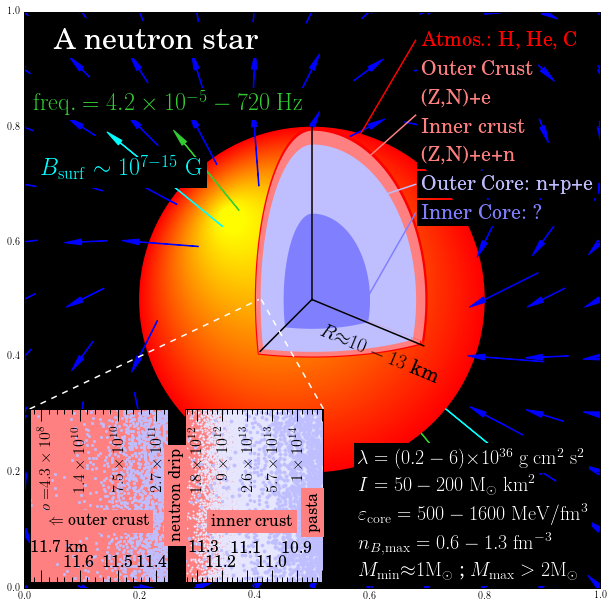

In [5]:
np=nstar_plot()
np.run()
if update_plot_files==True:
    plot.savefig('nstar_plot.eps')
    """
    Unfortunately the cutaway fills don't render properly on png
    output for some backends, so I use imagemagick to make .png
    instead.
    """
    os.system('convert nstar_plot.eps nstar_plot.png')
plot.show()

# Staged version

In [6]:
np.init()
np.bkgd()
np.base_star()
np.title(15)
if update_plot_files==True:
    plot.savefig('nstar_plot_stage1.eps')

In [7]:
np.init()
np.bkgd()
np.base_star()
np.cutaway(1.0,np.atmos_color,5)
np.cutaway(0.98,np.crust_color,6)
np.cutaway(0.9,np.core_color,7)
np.cutaway(0.5,np.inner_color,8)
np.title(15)
if update_plot_files==True:
    plot.savefig('nstar_plot_stage2.eps')

In [8]:
np.init()
np.bkgd()
np.base_star()
np.cutaway(1.0,np.atmos_color,5)
np.cutaway(0.98,np.crust_color,6)
np.cutaway(0.9,np.core_color,7)
np.cutaway(0.5,np.inner_color,8)
np.cutaway_axes(9)
np.title(15)
if update_plot_files==True:
    plot.savefig('nstar_plot_stage3.eps')

In [9]:
np.init()
np.bkgd()
np.base_star()
np.cutaway(1.0,np.atmos_color,5)
np.cutaway(0.98,np.crust_color,6)
np.cutaway(0.9,np.core_color,7)
np.cutaway(0.5,np.inner_color,8)
np.cutaway_axes(9)
np.cut_labels(9)
np.title(15)
if update_plot_files==True:
    plot.savefig('nstar_plot_stage4.eps')

In [10]:
np.init()
np.bkgd()
np.base_star()
np.cutaway(1.0,np.atmos_color,5)
np.cutaway(0.98,np.crust_color,6)
np.cutaway(0.9,np.core_color,7)
np.cutaway(0.5,np.inner_color,8)
np.cutaway_axes(9)
np.cut_labels(9)
np.crust_box2(10)
np.title(15)
if update_plot_files==True:
    plot.savefig('nstar_plot_stage5.eps')

In [11]:
np.init()
np.bkgd()
np.base_star()
np.mag_field(2)
np.rotation(2)
np.cutaway(1.0,np.atmos_color,5)
np.cutaway(0.98,np.crust_color,6)
np.cutaway(0.9,np.core_color,7)
np.cutaway(0.5,np.inner_color,8)
np.cutaway_axes(9)
np.cut_labels(9)
np.crust_box2(10)
np.title(15)
if update_plot_files==True:
    plot.savefig('nstar_plot_stage6.eps')

In [12]:
if update_plot_files==True:
    os.system('convert nstar_plot_stage1.eps nstar_plot_stage1.png')
    os.system('convert nstar_plot_stage2.eps nstar_plot_stage2.png')
    os.system('convert nstar_plot_stage3.eps nstar_plot_stage3.png')
    os.system('convert nstar_plot_stage4.eps nstar_plot_stage4.png')
    os.system('convert nstar_plot_stage5.eps nstar_plot_stage5.png')
    os.system('convert nstar_plot_stage6.eps nstar_plot_stage6.png')

# Version with a white background

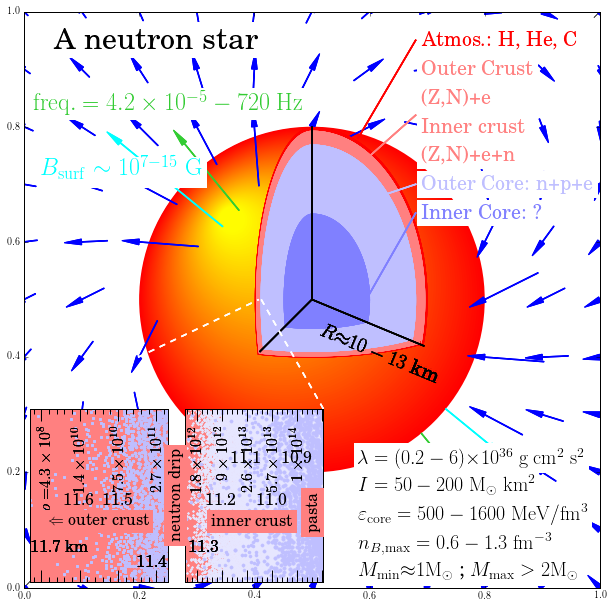

In [13]:
np.bkgd_color='white'
np.text_color='black'
np.run()
plot.show()